In [1]:
from utils import add_syn_mut_attribute, add_changes_from_root_attr, DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from datetime import datetime, date
import calendar
import random
import time
import math
import json
import string
import requests

### Find nonsynonymous and synonymous divergence in different genes and plot the ratio of dN/dS

In [2]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [3]:
def get_genome_info(virus, subtype, gene):
    """
    Read in the reference file and generate dictionaries that store sequence and position information for the functions below
    """
    configs = readin_virus_config(virus)
    
    
    # make dictionary with gene name as key and reference sequence of that gene as value
    reference_sequence_aa = {}
    reference_sequence_nt = {}

    # make dictionary giving gene by genomic location
    reference_gene_locations = {}

    # make dictionary saying what codon within the gene a certain genomic location falls within
    # and whether the mutation is at pos 0, 1 or 2 within codon
    reference_gene_codon = {}
    
    #for flu, only want subunits in HA, all other genes, just want the main coding region
    flu_genes = ["HA1", "HA2", "NA", "MA", "NP", "NS", "PA", "PB1", "PB2"]

    for record in SeqIO.parse(open(configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene),"r"), "genbank"):
        genome_seq = record.seq
        for feature in record.features:
            if feature.type == 'CDS':
                if 'gene' in feature.qualifiers:
                    #for flu viruses, prevent writing subunits like PB1-F2
                    if virus in ['h3n2', 'h1n1pdm', 'vic', 'yam']: 
                        if feature.qualifiers['gene'][0] in flu_genes:
                            for pos in range(int(feature.location.start), int(feature.location.end)):
                                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                                codon_num = math.floor((pos-feature.location.start)/3)
                                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                            gene_seq = feature.location.extract(record.seq)
                            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
                            gene_seq_aa = gene_seq.translate()
                            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa
                    #for other viruses
                    else:
                        for pos in range(int(feature.location.start), int(feature.location.end)):
                            reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                            codon_num = math.floor((pos-feature.location.start)/3)
                            pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                            reference_gene_codon[pos] = (codon_num, pos_in_codon)

                        gene_seq = feature.location.extract(record.seq)
                        reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
                        gene_seq_aa = gene_seq.translate()
                        reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

    # make dictionary with length of each gene
    gene_lengths_aa = {k:len(v) for k,v in reference_sequence_aa.items()}
    
    return reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa


In [4]:
def get_tree(virus, subtype, gene):
    """
    Read in the tree and add an attribute to each node listing synonymous mutations
    """
    
    configs = readin_virus_config(virus)
    
    reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa = get_genome_info(virus, subtype, gene)
    
    #all genes in the genome
    gene_list = list(gene_lengths_aa.keys())
    
    tree_json_file = configs['tree_file'].format(virus=virus, subtype=subtype, gene=gene)
    
    with open(tree_json_file, 'r') as f:
        tree_json = json.load(f)

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    #add synonymous mutations as an attribute of the tree
    tree = add_syn_mut_attribute(tree, reference_gene_locations, 
                                 reference_gene_codon,
                                 reference_sequence_nt, 
                                 reference_sequence_aa)
    
    #add an attribute to each node that lists all mutations that have occurred between the root and node
    tree = add_changes_from_root_attr(tree, gene_list)
    
    return tree

For each time window, compute dN/dS for each isolate within the window. For each internal branch, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [5]:
def find_duplication_pos(subtype):
    """
    For RSV only. Since divergence is being measured from the root, and all root sequences 
    will not have the duplication (just --- at this region), and it doesn't make 
    sense to compute divergence from ---, want to ignore duplicated region
    Also ignore template of duplication for now
    """
    with open(f'../rsv/rsv_builds_for_divergence/auspice/rsv_{subtype}_root-sequence.json', 'r') as f:
        root_json = json.load(f)
        
    duplication_len = {'A':72, 'A1':72, 'A2':72, 'B': 60}
    
    #location of the duplication within the genome
    loc_dup_start = root_json['nuc'].find('-'*duplication_len[subtype])
    
    loc_dup = (loc_dup_start, loc_dup_start+duplication_len[subtype])
    
    #location of the duplication within G
    for record in SeqIO.parse(open(f"../rsv/rsv_builds_for_divergence/config/rsv_{subtype}_step3_reference.gb","r"), "genbank"):
        for feature in record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'][0] == 'G':
                    G_start = feature.location.start

                    
    loc_dup_start_G = loc_dup_start - G_start
    
    loc_dup_G_nt = (loc_dup_start_G, loc_dup_start_G+duplication_len[subtype])
    loc_dup_G_aa = tuple(int(x/3) for x in loc_dup_G_nt)

    
    return loc_dup, loc_dup_G_aa, loc_dup_G_nt

In [6]:
def find_nonsyn_syn_denominators(virus, subtype, reference_sequence_nt, reference_sequence_aa):
    
    
    # get the position of the duplication, to ignore this region
    if virus=='rsv':
        loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    
    denominators = {}
    
    for gene,nt_seq in reference_sequence_nt.items():
        
        seq = str(nt_seq)
        aa_seq = str(reference_sequence_aa[gene])


        nonsyn_denominator = 0
        syn_denominator = 0

        all_nts = ['A', 'C', 'G', 'T']

        for pos in range(len(seq)):
            #remove duplication region
            if virus=='rsv' and gene == 'G' and pos in range(loc_dup_G_nt[0],loc_dup_G_nt[1]):
                pass
                
            else:
                nt = seq[pos]
                if nt!='N':

                    codon = math.floor(pos/3)
                    codon_pos = pos-(codon*3)
                    #some references include stop codon, some don't
                    if codon < len(aa_seq):
                        real_codon_aa = aa_seq[codon]

                        all_other_nts = [x for x in all_nts if x != nt]
                        for mutated_nt in all_other_nts: 
                            if codon_pos == 0:
                                mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                            elif codon_pos == 1:
                                mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                            elif codon_pos == 2:
                                mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                            mut_codon_aa = Seq(mut_codon_nt).translate()

                            if mut_codon_aa!=real_codon_aa:
                                nonsyn_denominator+=1
                            elif mut_codon_aa==real_codon_aa:
                                syn_denominator+=1
                        
            
        denominators[gene] = {'nonsyn_denominator': nonsyn_denominator, 'syn_denominator':syn_denominator}
        
    return denominators

Time windows for Fig2 will be 2 calendar months, and human readable. Make a list of time window start and end dates, in human readable dates and decimal years. For plotting, use the date at the middle of the window. For example, if window includes all of March and April 2020 (Mar-01-2020 to Apr-30-2020), plot this at April 1 2020. Use sliding windows that overlap by one month

In [7]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [8]:
# find the start date and end date of the build

def get_build_dates(tree):
    
    last_timepoint = 0
    first_timepoint = 2020
    for node in tree.find_clades():
        if node.node_attrs['num_date']['value'] > last_timepoint:
            last_timepoint = node.node_attrs['num_date']['value']
        if node.node_attrs['num_date']['value'] < first_timepoint:
            first_timepoint = node.node_attrs['num_date']['value']
    
    last_date = DateToStr(last_timepoint)
    last_date = datetime.strptime(last_date, '%b-%d-%Y')
    first_date = DateToStr(first_timepoint)
    first_date = datetime.strptime(first_date, '%b-%d-%Y')
    
    return first_date, last_date

In [9]:
def make_time_windows(tree, window_size):
    """
    Make sliding windows of length `window_size` (in years) that are offset by 1 year
    """
    
    first_date, last_date = get_build_dates(tree)
    
    time_windows = []

    for year in range(first_date.year, last_date.year-window_size):
        window_start = year
        window_end = year+window_size
        window_midpoint = (window_start+window_end)/2
        window_midpoint_str = DateToStr(window_midpoint)
     
        time_windows.append({'window_start_decimal': float(window_start), 
                             'window_end_decimal': float(window_end), 'window_midpoint_decimal': float(window_midpoint), 
                        'window_start': datetime.strptime(str(window_start), '%Y'), 
                        'window_end': datetime.strptime(str(window_end), '%Y'), 
                        'window_midpoint': datetime.strptime(window_midpoint_str, '%b-%d-%Y')})
                
    return time_windows

In [10]:
def mask_duplication_region_aa(subtype, mut_list):
    
    loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    mut_pos = [x[1:-1] for x in mut_list]
    
    mut_list_masked = []
    for x in mut_list:
        if int(x[1:-1]) not in range(loc_dup_G_aa[0], loc_dup_G_aa[1]):
            mut_list_masked.append(x)
            
    
    return mut_list_masked


In [11]:
def mask_duplication_region_nt(subtype, mut_list):
    
    loc_dup, loc_dup_G_aa, loc_dup_G_nt = find_duplication_pos(subtype)
    
    mut_pos = [x[1:-1] for x in mut_list]
    
    mut_list_masked = []
    for x in mut_list:
        if int(x[1:-1]) not in range(loc_dup[0], loc_dup[1]):
            mut_list_masked.append(x)
            
    
    return mut_list_masked


In [12]:
def get_divergence_over_time(virus, subtype, window_size):
    
    #get configs for virus
    configs = readin_virus_config(virus)

    #find whether trees are built on genome or individual genes
    if configs['tree_type']=='genome':
        #get genome info
        reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa = get_genome_info(virus,subtype,None)

        #get list of genes in genome
        gene_list = list(gene_lengths_aa.keys())
        #get tree
        tree = get_tree(virus, subtype, None)
        #get expected syn and nonsyn sites 
        denominators = find_nonsyn_syn_denominators(virus, subtype, reference_sequence_nt, reference_sequence_aa)
        all_genes_df = find_divergence_in_window(virus, subtype, tree, gene_list, denominators, window_size)
        
    elif configs['tree_type']=='gene-specific':
        all_genes_df = pd.DataFrame()
        for gene in configs["genes_for_divergence"]:
            #get genome info
            reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa = get_genome_info(virus,subtype,gene)
            #get tree
            tree = get_tree(virus, subtype, gene)
            #get expected syn and nonsyn sites 
            denominators = find_nonsyn_syn_denominators(virus, subtype, reference_sequence_nt, reference_sequence_aa)
            #get list of subunits in this gene
            subunit_list = list(gene_lengths_aa.keys())
            tips_in_window_dnds_df = find_divergence_in_window(virus, subtype, tree, subunit_list, denominators, window_size)
            all_genes_df = pd.concat([all_genes_df,tips_in_window_dnds_df])
        
    
    # get genome-wide average dnds at each time point
    date_groups = all_genes_df.groupby('window_start')[['dn/ds', 'ds', 'dn', 'window_end', 'window_midpoint']].mean()
    start_dates = list(set(list(all_genes_df['window_start'])))
    for date in start_dates:
        all_genes_df = pd.concat([all_genes_df, pd.DataFrame([{'window_start': date,  
                                      'window_end': date_groups['window_end'][date], 
                                      'window_midpoint': date_groups['window_midpoint'][date], 
                                      'dn': date_groups['dn'][date], 'ds': date_groups['ds'][date],
                                      'dn/ds':date_groups['dn/ds'][date], 
                                      'location': 'genome_avg'}])], ignore_index=True)
    
    return all_genes_df


In [13]:
def find_divergence_in_window(virus, subtype, tree, gene_list, denominators, window_size):

    
    #make sliding time windows
    time_windows = make_time_windows(tree, window_size)
    
    #store dn, ds, dn/ds info for each tip in window
    individual_tip_dnds_info = []
    

    
    # look at divergence within time window
    for x in range(0,len(time_windows)):
        start_date = float(time_windows[x]['window_start_decimal'])
        end_date = float(time_windows[x]['window_end_decimal'])
        
        # keep track of all tips in window
        nonsyn_div_in_window = {g:[] for g in gene_list}
        syn_div_in_window = {g:[] for g in gene_list}

        for node in tree.find_clades(terminal=False):
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                for gene in gene_list:
                    gene_nonsyn_denom = denominators[gene]['nonsyn_denominator'] 
                    gene_syn_denom = denominators[gene]['syn_denominator']
                    
                    #divergence accumulation
                    #mask duplication region for rsv
                    if virus =='rsv':
                        nonsyn_muts = mask_duplication_region_aa(subtype, node.branch_attrs["changes_from_root"]['nonsyn'][gene])
                    else:
                        nonsyn_muts = node.branch_attrs["changes_from_root"]['nonsyn'][gene]
                    gene_nonsyn_divergence = len(nonsyn_muts)/gene_nonsyn_denom
                    
                    
                    if virus=='rsv':
                        syn_muts = mask_duplication_region_nt(subtype, node.branch_attrs["changes_from_root"]['syn'][gene])
                    else:
                        syn_muts = node.branch_attrs["changes_from_root"]['syn'][gene]
                    gene_syn_divergence = len(syn_muts)/gene_syn_denom
                    
                    #assign a false count to avoid dividing by zero                  
                    if len(syn_muts) == 0:
                        gene_syn_divergence_adjusted = 1/gene_syn_denom
                    else:
                        gene_syn_divergence_adjusted = gene_syn_divergence
                    
                    nonsyn_div_in_window[gene].append(gene_nonsyn_divergence)
                    syn_div_in_window[gene].append(gene_syn_divergence)
                    
                    #dn/ds on this tip
                    dn_over_ds = gene_nonsyn_divergence/gene_syn_divergence_adjusted
                    
                    individual_tip_dnds_info.append({'window_start': time_windows[x]['window_start_decimal'],  
                                             'window_end': time_windows[x]['window_end_decimal'], 
                                             'window_midpoint': time_windows[x]['window_midpoint_decimal'], 
                                             'dn': gene_nonsyn_divergence, 'ds': gene_syn_divergence,
                                             'dn/ds':dn_over_ds, 'location': gene.upper()})
            
    
    # contains dn and ds info for each tip, dnds is also calculated on each tip
    tips_in_window_dnds_df = pd.DataFrame(individual_tip_dnds_info)

        

    return tips_in_window_dnds_df
        

In [14]:
def run_divergence_analysis_multiple_viruses(viruses, window_size=10):
    """
    Run divergence accumulation analysis for all viruses and subtypes specified. 
    Return a dictionary of dataframes containing this analysis
    """
    all_virus_dfs = {}
    
    for virus in viruses:
        #get configs for virus
        configs = readin_virus_config(virus)
        if configs['subtype']=="True":
            subtypes = configs['subtypes']
            for s in subtypes:
                df = get_divergence_over_time(virus, s, window_size)
                all_virus_dfs[f'{virus}-{s}'] = df
            
            

    
        else:
            df = get_divergence_over_time(virus, None, window_size)
            all_virus_dfs[f'{virus}'] = df
        
    return all_virus_dfs
    

In [15]:
first_virus_dfs = run_divergence_analysis_multiple_viruses(['rsv', 'measles', 'h3n2', 'mumps'])

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [16]:
more_virus_dfs = run_divergence_analysis_multiple_viruses(['h1n1pdm', 'vic', 'yam'])

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [17]:
oc43_df = run_divergence_analysis_multiple_viruses(['oc43'])

In [18]:
nl63_df = run_divergence_analysis_multiple_viruses(['nl63'])

In [19]:
cov229e_df = run_divergence_analysis_multiple_viruses(['229e'])

In [20]:
virus_dfs = {**first_virus_dfs, **more_virus_dfs, **nl63_df, **oc43_df, **cov229e_df}

In [21]:
def compare_divergence_accumulation(viruses_to_plot, input_dict, divergence_to_plot, 
                                    compare_to, filename=None):
    
    fig, axs = plt.subplots(round(len(viruses_to_plot)/2),2,figsize=(10, (len(viruses_to_plot)*1.2)), sharey='row')
    
    axs = axs.flatten()
    
    prettify_titles = {'rsv-A': 'RSV-A', 'rsv-B': 'RSV-B', 'measles': 'Measles', 'mumps': 'Mumps',
                       'h3n2': 'Influenza A/H3N2', 'h1n1pdm': 'Influenza A/H1N1pdm', 
                       'vic': 'Influenza B/Vic', 'yam': 'Influenza B/Yam',
                       '229e': 'hCoV-229E', 'nl63': 'hCoV-NL63', 
                       'oc43-a': 'hCoV-OC43-A', 'oc43-b': 'hCoV-OC43-B'}
    
    whether_to_plot_legend = {x:False for x in range(len(viruses_to_plot))}
    whether_to_plot_legend[1] = True
    
    for i in range(len(viruses_to_plot)):
        virus = viruses_to_plot[i]

        #check if there is a subtype
        if '-' in virus:
            v= virus.split('-')[0]
            s=virus.split('-')[1]
            configs = readin_virus_config(v)
            color = configs['color'][s]
        else:
            configs = readin_virus_config(virus)
            color = configs['color']
        
        #plot the receptor-binding gene
        if compare_to == 'polymerase':
            compare_to_gene = configs['polymerase']['virus_gene'].upper()
            compare_to_label = 'Polymerase'
        elif compare_to == 'genome_avg':
            compare_to_gene = 'genome_avg'
            compare_to_label = 'Genome Average'
        genes_to_plot = [configs['receptor_binding']['virus_gene'].upper(), compare_to_gene]
        gene_to_plot_2 = configs['membrane_fusion']['virus_gene'].upper()
        
        input_df = input_dict[virus]
        df_to_plot = input_df[input_df['location'].isin(genes_to_plot)]
        df_to_plot2 = input_df[input_df['location']==gene_to_plot_2]
        
        #truncate plot to only dates included on gene_to_plot's tree, or later
        min_date = df_to_plot[df_to_plot['location']==genes_to_plot[0]]['window_start'].min()
        if virus=='nl63':
            min_date = 1975.0
        if virus=='oc43-b':
            min_date = 1970.0
        df_to_plot = df_to_plot[df_to_plot['window_start']>=min_date]
        df_to_plot2 = df_to_plot2[df_to_plot2['window_start']>=min_date]
        

        cmap = {genes_to_plot[0]: color, gene_to_plot_2: color, 'genome_avg': '#737373', genes_to_plot[1]:'#737373'}
        

        axs[i] = sns.lineplot(x='window_start', y=divergence_to_plot.lower(), hue='location', 
                      data=df_to_plot, palette=cmap, linewidth=2, hue_order = genes_to_plot, 
                      ci=95, ax=axs[i], legend=False)
        
        axs[i] = sns.lineplot(x='window_start', y=divergence_to_plot.lower(), hue='location', linestyle=':',
                              data=df_to_plot2, alpha=0.4,
                              palette=cmap, linewidth=2, err_kws={"alpha": 0.1},
                              ci=95, ax=axs[i], legend=False)
        
        axs[i].set_title(f'{prettify_titles[virus]}', fontsize=14)
        
        axs[i].tick_params(axis='both',labelsize=12)
        axs[i].set_xlabel('', fontsize=14)
        #label y-axis on outer plots only
        if i%2==0:
            axs[i].set_ylabel(f'{divergence_to_plot}', fontsize=14)
        else:
            axs[i].set_ylabel('', fontsize=14)


#         fig.suptitle(f'{virus} divergence accumulation', fontsize=16)
        plt.tight_layout()
        sns.set_style("white")
        sns.despine(left=False, bottom=False)


#     handles, labels = axs[1].get_legend_handles_labels()

    custom_handles = [Line2D([0], [0], color="#F5AD52", lw=4),
                Line2D([0], [0], color="#F5AD52", alpha=0.4, ls=':', lw=4),
                Line2D([0], [0], color='#737373', lw=4)]

    lgd = axs[1].legend(custom_handles, ['Receptor Binding', 'Membrane Fusion', compare_to_label], 
                         loc='upper center', fontsize=12, bbox_to_anchor=(1.3, 1.0), 
                             title = r'$\bf{Gene}$')
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

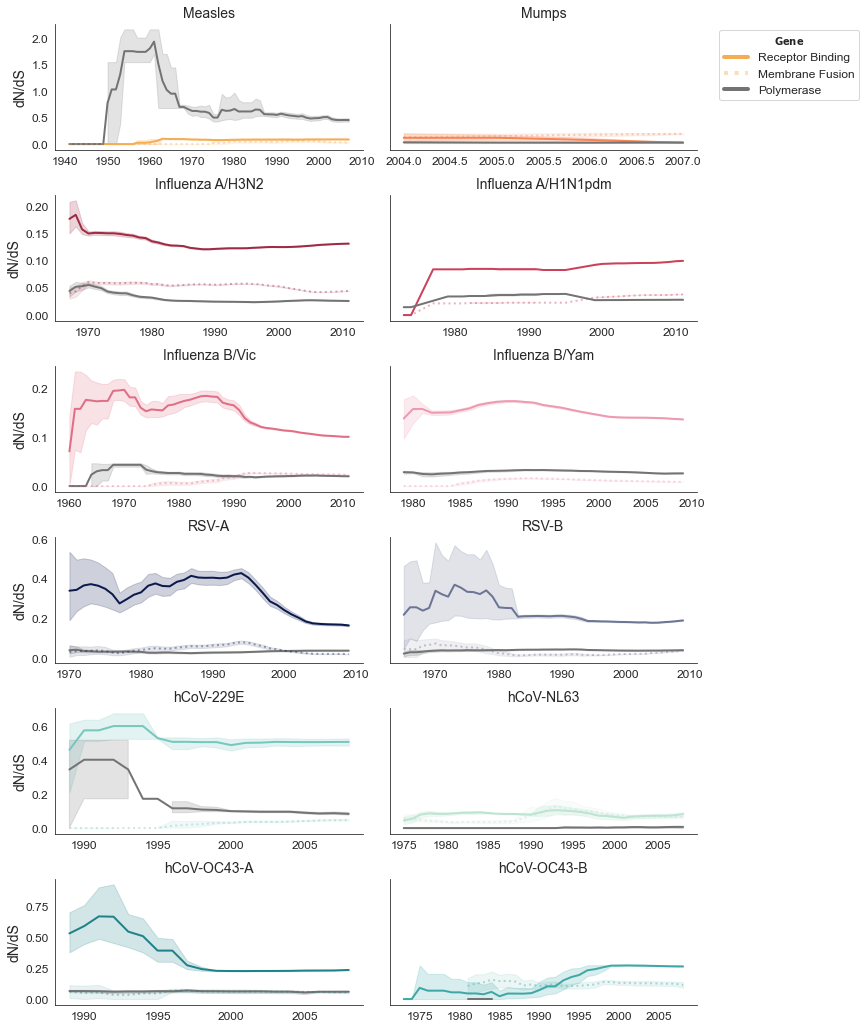

In [272]:
compare_divergence_accumulation(['measles', 'mumps',
                                 'h3n2', 'h1n1pdm', 'vic', 'yam',
                                 'rsv-A', 'rsv-B',
                                 '229e', 'nl63', 'oc43-a', 'oc43-b'], 
                                virus_dfs, 'dN/dS', 'polymerase', 'plots/dnds_comparison.png')

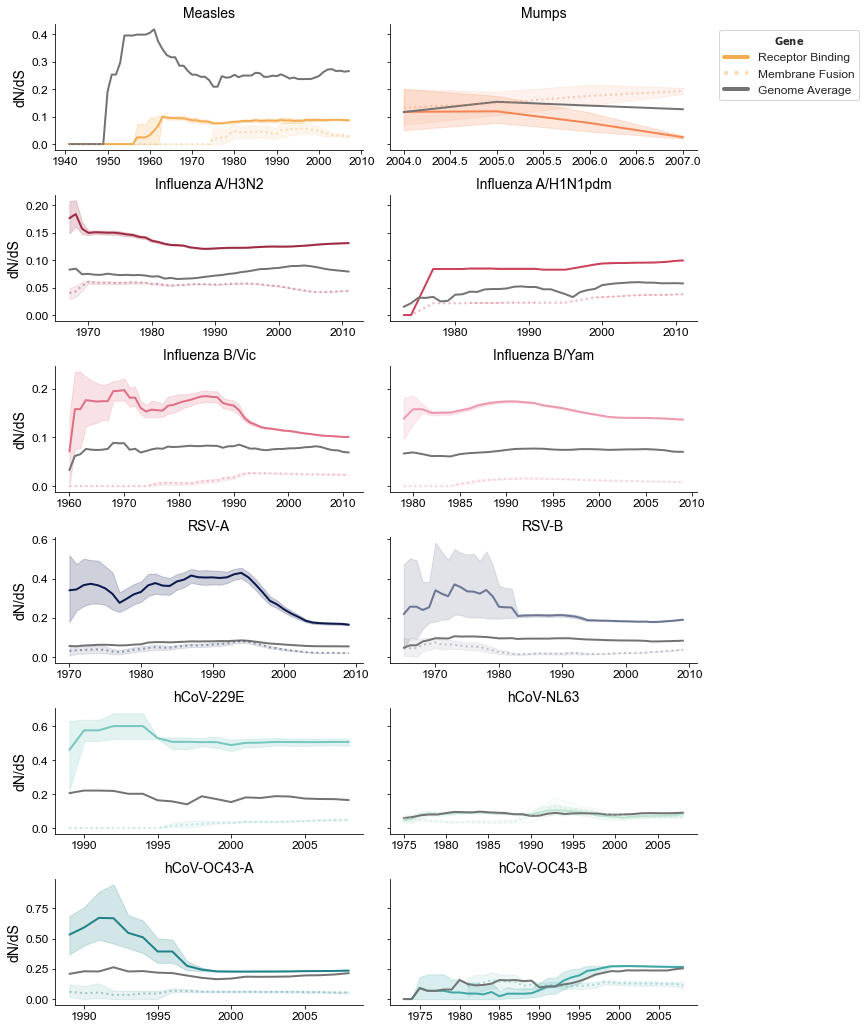

In [22]:
compare_divergence_accumulation(['measles', 'mumps',
                                 'h3n2', 'h1n1pdm', 'vic', 'yam',
                                 'rsv-A', 'rsv-B',
                                 '229e', 'nl63', 'oc43-a', 'oc43-b'], 
                                virus_dfs, 'dN/dS', 'genome_avg', 'plots/dnds_compare-to-genomeavg.png')

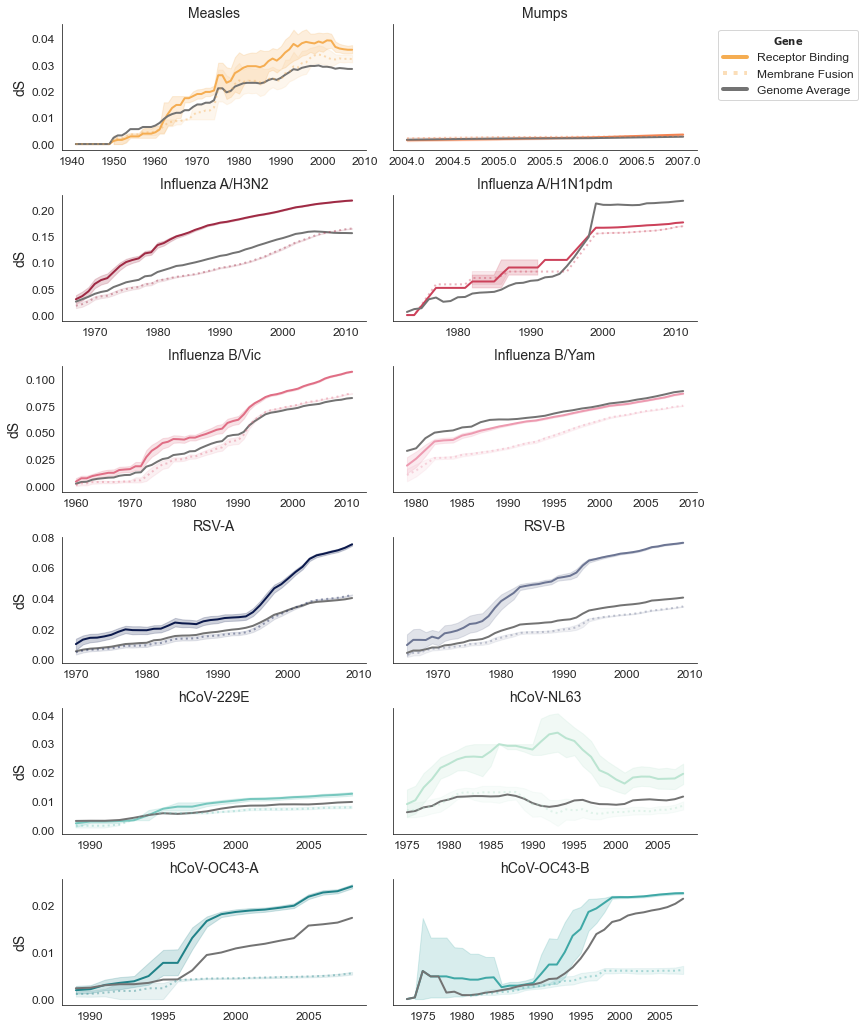

In [23]:
compare_divergence_accumulation(['measles', 'mumps',
                                               'h3n2', 'h1n1pdm', 'vic', 'yam',
                                               'rsv-A', 'rsv-B',
                                               '229e', 'nl63', 'oc43-a', 'oc43-b'], 
                                              virus_dfs, 'dS', 'genome_avg', 'plots/ds_compare-to-genomeavg.png')

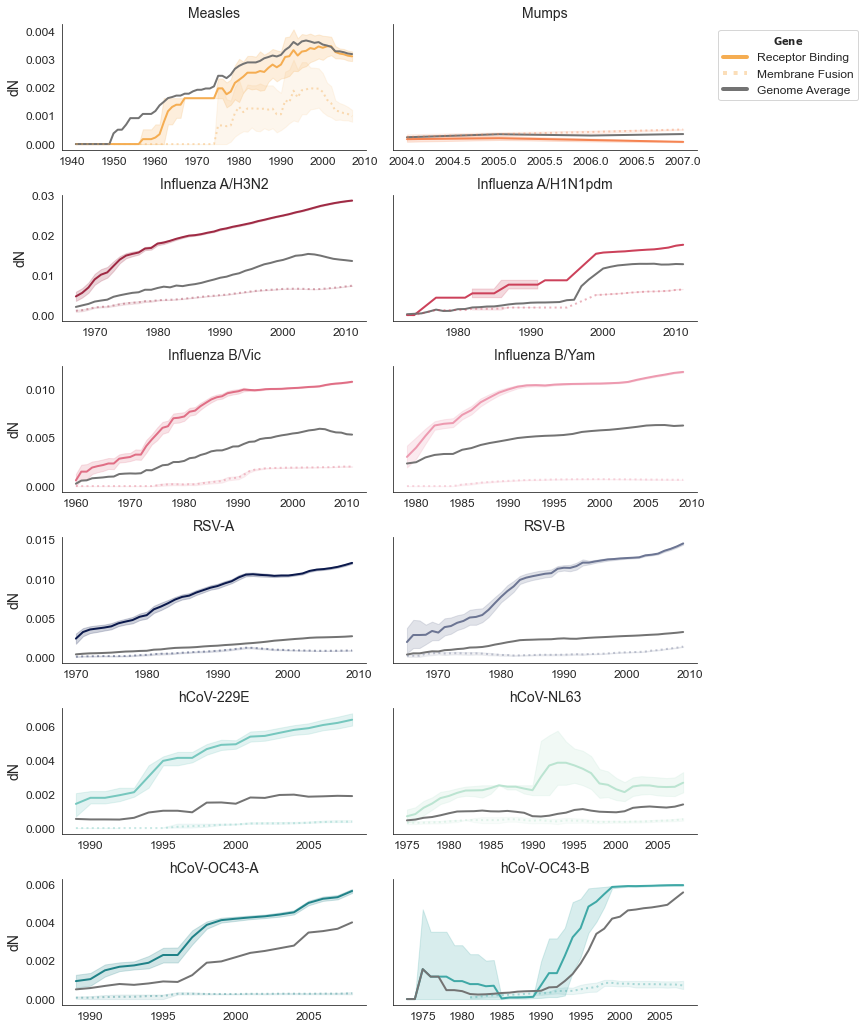

In [24]:
compare_divergence_accumulation(['measles', 'mumps',
                                               'h3n2', 'h1n1pdm', 'vic', 'yam',
                                               'rsv-A', 'rsv-B',
                                               '229e', 'nl63', 'oc43-a', 'oc43-b'], 
                                              virus_dfs, 'dN', 'genome_avg', 'plots/dn_compare-to-genomeavg.png')